In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, roc_curve, auc,confusion_matrix, RocCurveDisplay

### Importing the Data set, Cleaning Data and Handling Missing Values

In [2]:
df = pd.read_csv('sgl-arbres-urbains-wgs84.csv')

In [3]:
df= df.drop(["ID_ARBRE", "commune", "controle", "insecte_collet", "insecte_tronc", "insecte_houppier","circonference (en cm)", "observation_collet", "observation_tronc", "observation_houppier"], axis=1 )
#Handling Missing Values
mode_cote_voirie=df.cote_voirie.mode()[0]
mode_espece_arbre=df.espece_arbre.mode()[0]
mode_situation=df.situation.mode()[0]
mode_plaie_collet=df.plaie_collet.mode()[0]
mode_champignon_tronc=df.champignon_tronc.mode()[0]
mode_fissure_tronc=df.fissure_tronc.mode()[0]
mode_rejet_tronc=df.rejet_tronc.mode()[0]
mode_plaie_tronc=df.plaie_tronc.mode()[0]
mode_champignon_houppier=df.champignon_houppier.mode()[0]
mode_fissure_houppier=df.fissure_houppier.mode()[0]
mode_ecorce_incluse_houppier=df.ecorce_incluse_houppier.mode()[0]
mode_bois_mort_houppier=df.bois_mort_houppier.mode()[0]
mode_plaie_houppier=df.plaie_houppier.mode()[0]
mode_contrainte=df.contrainte.mode()[0]
mode_classification_diagnostic=df.classification_diagnostic.mode()[0]
median_esperance_maintien=df.esperance_maintien.median()

df=df.fillna({"cote_voirie": mode_cote_voirie, "espece_arbre": mode_espece_arbre, "situation": mode_situation,
            "plaie_collet": mode_plaie_collet, "champignon_tronc": mode_champignon_tronc,
            "fissure_tronc": mode_fissure_tronc, "rejet_tronc": mode_rejet_tronc, "plaie_tronc": mode_plaie_tronc, 
              "champignon_houppier": mode_champignon_houppier, "fissure_houppier":mode_fissure_houppier, "ecorce_incluse_houppier": mode_ecorce_incluse_houppier,
            "bois_mort_houppier": mode_bois_mort_houppier, "plaie_houppier": mode_plaie_houppier, "contrainte": mode_contrainte,
            "classification_diagnostic": mode_classification_diagnostic, "esperance_maintien": median_esperance_maintien})

In [4]:
#define function to swap columns so that all numerical data will be in the end columns
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    a, b = col_list.index(col1), col_list.index(col2)
    col_list[b], col_list[a] = col_list[a], col_list[b]
    df = df[col_list]
    return df

#swaping columns
df = swap_columns(df, 'matricule_arbre', 'contrainte')
df = swap_columns(df, 'surf_permeable', 'plaie_houppier')
df = swap_columns(df, 'date_plantation', 'bois_mort_houppier')
df = swap_columns(df, 'hauteur', 'ecorce_incluse_houppier')
df = swap_columns(df, 'diametre', 'fissure_houppier')


In [5]:
target_name = "classification_diagnostic"
target = df[target_name]
data = df.drop(columns=[target_name])

In [6]:
from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)

categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value",
                                          unknown_value=-1)
preprocessor = ColumnTransformer([
    ('cat_preprocessor', categorical_preprocessor, categorical_columns)],
    remainder='passthrough', sparse_threshold=0)
X_train, X_test, y_train, y_test = train_test_split(
    data, target, random_state=0, test_size=0.1)

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier


In [1]:
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_predict

In [14]:
classifier_1 = GradientBoostingClassifier(loss='deviance', learning_rate=0.01, subsample=0.7, n_estimators=350, max_depth=6, max_leaf_nodes=16, random_state=0,)
model_gdbst_1 = Pipeline([("preprocessor", preprocessor), ("classifier", classifier_1),])
model_gdbst_1.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('cat_preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['quartier', 'site',
                                                   'cote_voirie', 'contrainte',
                                                   'genre_arbre',
                                                   'espece_arbre', 'situation',
                                                   'type_sol', 'plaie_houppier',
                                                   'bois_mort_houppier',
                                                   'classe_age',
                                                   'ecorc...
                                                   'cla

In [ ]:
plt.bar(range(len(model_gdbst_1.feature_importances_)), model_gdbst_1.feature_importances_)
plt.show()

AttributeError: 'Pipeline' object has no attribute 'feature_importances_'

In [10]:
%%time
from sklearn.model_selection import cross_val_score

accuracies = cross_val_score(estimator = model_gdbst_1.fit(X_train, y_train), X=X_train, y=y_train, cv = 5)
print(accuracies)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

[0.859375   0.8515625  0.875      0.86614173 0.8503937 ]
Accuracy: 86.05 %
Standard Deviation: 0.92 %
Wall time: 13.1 s


In [9]:
%%time
n_est=[]
results_gbll_1=[]
results_gbll_2=[]
results_gbll_3=[]
for i in range (1, 400, 10):
    log_j_1 =[]
    log_j_2 =[]
    log_j_3 =[]
    for j in range (1, 4, 1):
        classifier_1 = GradientBoostingClassifier(loss='deviance', learning_rate=1, subsample=1, n_estimators=i, max_depth=6, max_leaf_nodes=16, random_state=j,)
        model_gdbst_1 = Pipeline([("preprocessor", preprocessor), ("classifier", classifier_1),])
        model_gdbst_1.fit(X_train, y_train)
        log_ii_1 = log_loss(y_test, model_gdbst_1.predict_proba(X_test))
        log_j_1.append(log_ii_1)

        classifier_2 = GradientBoostingClassifier(loss='deviance', learning_rate=0.01, subsample=1, n_estimators=i, max_depth=6, max_leaf_nodes=16, random_state=j,)
        model_gdbst_2 = Pipeline([("preprocessor", preprocessor), ("classifier", classifier_2),])
        model_gdbst_2.fit(X_train, y_train)
        log_ii_2 = log_loss(y_test, model_gdbst_2.predict_proba(X_test))
        log_j_2.append(log_ii_2)

        classifier_3 = GradientBoostingClassifier(loss='deviance', learning_rate=0.01, subsample=0.7, n_estimators=i, max_depth=6, max_leaf_nodes=16, random_state=j,)
        model_gdbst_3 = Pipeline([("preprocessor", preprocessor), ("classifier", classifier_3),])
        model_gdbst_3.fit(X_train, y_train)
        log_ii_3 = log_loss(y_test, model_gdbst_3.predict_proba(X_test))
        log_j_3.append(log_ii_3)  
    n_est.append(i)
    results_gbll_1.append(log_j_1)
    results_gbll_2.append(log_j_2)
    results_gbll_3.append(log_j_3)
    #results_gbll.append(np.mean(log_j, axis=0))

Wall time: 9min 6s


In [10]:
print(np.mean(results_gbll_1, axis=1))
print(np.mean(results_gbll_2, axis=1))
print(np.mean(results_gbll_3, axis=1))

[1.64935945 1.85665681 2.14975978 2.46827426 2.67910941 2.89154756
 3.08789938 3.23747778 3.38558095 3.60581293 3.74313537 3.82061551
 3.85500455 3.99418783 4.11089976 4.2147731  4.24024716 4.27969002
 4.31573365 4.35298588 4.37983994 4.41882992 4.43648753 4.45423363
 4.46550123 4.47676884 4.48428058 4.48738116 4.48738116 4.48738116
 4.48738116 4.48738116 4.48738116 4.48738116 4.48738119 4.48738289
 4.48742344 4.49319039 4.50668253 4.53665203]
[1.11632043 0.99050902 0.90381335 0.84071405 0.78312019 0.73225576
 0.69727481 0.67295338 0.65096951 0.63259895 0.61746841 0.60543427
 0.59531963 0.58462604 0.57703057 0.57019943 0.56429737 0.5584897
 0.55536236 0.55209333 0.54974861 0.55116331 0.55105087 0.55169615
 0.55302584 0.5541561  0.55444961 0.55618894 0.55792624 0.55907406
 0.56094326 0.56420747 0.56676714 0.57006177 0.57130549 0.57405338
 0.57672251 0.5794703  0.58137082 0.58391771]
[1.12180672 0.9747582  0.88419051 0.81435767 0.76178829 0.7203894
 0.68619096 0.65910056 0.6340505  0.614

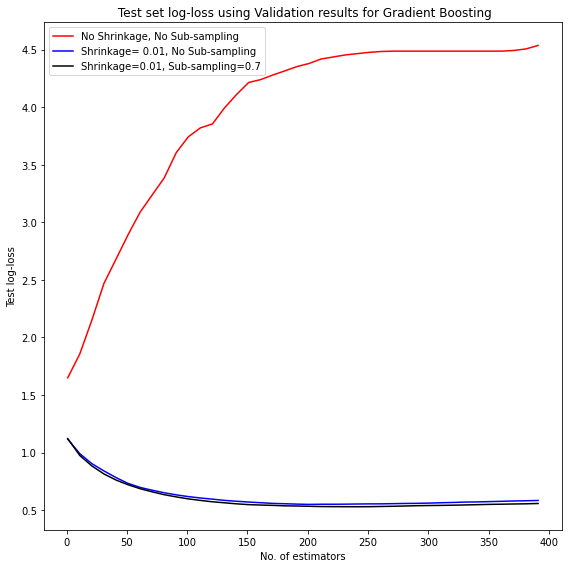

In [11]:
plt.subplots(1, figsize=(8,8))
plt.plot(n_est, np.mean(results_gbll_1, axis=1), label="No Shrinkage, No Sub-sampling", color="red")
plt.plot(n_est, np.mean(results_gbll_2, axis=1), label="Shrinkage= 0.01, No Sub-sampling", color="blue")
plt.plot(n_est, np.mean(results_gbll_3, axis=1), label="Shrinkage=0.01, Sub-sampling=0.7", color="black")
plt.title(' Test set log-loss using Validation results for Gradient Boosting')
plt.xlabel("No. of estimators")
plt.ylabel("Test log-loss")
plt.tight_layout()
plt.legend(loc="best")
#plt.xticks(np.arange( 1, 100, 10))
plt.show()

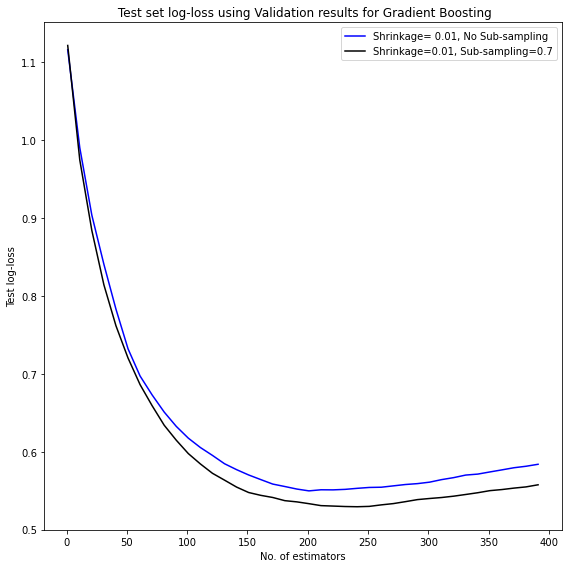

In [12]:
plt.subplots(1, figsize=(8,8))
#plt.plot(n_est, np.mean(results_gbll_1, axis=1), label="No Shrinkage, No Sub-sampling", color="red")
plt.plot(n_est, np.mean(results_gbll_2, axis=1), label="Shrinkage= 0.01, No Sub-sampling", color="blue")
plt.plot(n_est, np.mean(results_gbll_3, axis=1), label="Shrinkage=0.01, Sub-sampling=0.7", color="black")
plt.title(' Test set log-loss using Validation results for Gradient Boosting')
plt.xlabel("No. of estimators")
plt.ylabel("Test log-loss")
plt.tight_layout()
plt.legend(loc="best")
#plt.xticks(np.arange( 1, 100, 10))
plt.show()